In [2]:
# !python drive/MyDrive/MovieScriptNLPAnalysis/json_to_dataframe.py

In [3]:
# !pip install stanza
# !rm -rf drive/MyDrive/MovieScriptNLPAnalysis
# ! git clone https://github.com/SevenYoshis/MovieScriptNLPAnalysis/ drive/MyDrive/MovieScriptNLPAnalysis

In [4]:
import os
import pandas as pd
import re
import stanza
import numpy as np
import plotly.express as px
from tqdm import tqdm
tqdm.pandas()

In [5]:
recalculate_all = False

In [6]:
# !git clone https://github.com/SevenYoshis/MovieScriptNLPAnalysis/ drive/MyDrive/MovieScriptNLPAnalysis
base_path = '.'
spreadsheets_path = 'Movie_spreadsheets'
data_path = os.path.join(base_path, spreadsheets_path)
intermediate_path = os.path.join(base_path, 'intermediate')

## Cleaning messy scripts

In [7]:
def split_lines_with_character_tags(df):
    df['line #'] = df.index
    df['line'] = df['line'].str.replace('\n', ' ')
    # print(df)
    df = df[df['character'].str.isupper()]
    df['character'] = df['character'].str.replace(r"\(.+\)", '').str.strip()
    df['original character'] = df['character']

    df['line'] = df['line'].str.replace(r'\(cont.+d\)', '', flags=re.IGNORECASE)
    df = df[df['character'].str.strip().str.len() != 0]


    for character in df['original character'].unique():
        while len(df[df['line'].str.contains(re.escape(character))]) > 0:
            new_rows = df[df['line'].str.contains(character)].copy()
            new_rows.loc[:,'line'] = new_rows['line'].str.split(character).apply(lambda x: x[1])
            df.loc[:,'line'] = df['line'].str.split(character).apply(lambda x: x[0])
            new_rows['character'] = character
            new_rows.loc[:,'line #'] += .001
            df = df.append(new_rows)
            df = df.sort_values(by='line #').reset_index(drop=True)
            df.loc[:, 'line #'] = df.index

    df = df.drop('original character', axis=1)        
    df['character'] = df['character'].str.replace(r'[^A-z]','')

    df = df[df['line'].str.strip().str.len() != 0]
    df = df[df['character'].str.strip().str.len() != 0]
    return df

In [8]:
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
if recalculate_all:
    df = pd.DataFrame()
    movie_id = 0
    for file in tqdm(sorted(os.listdir(data_path))):
        if file.endswith('.csv'):
            movie_title = file.replace('.csv', '')
            # print(movie_title)
            individual_df = pd.read_csv(os.path.join(data_path, file), index_col=0)
            # print(file)
            # print(individual_df.head())
            individual_df['movie_id'] = movie_id
            movie_id += 1
            individual_df['movie_title'] = movie_title
            individual_df = split_lines_with_character_tags(individual_df)
            df = df.append(individual_df)

    # Weird problem in the labeling of Black Panther
    df = df[~df['character'].isin(['T', 'A', 'N'])]

In [10]:
if recalculate_all:
    character_counts = pd.DataFrame(df.groupby(['character', 'movie_title'])['line #'].count())
    character_counts.hist()

In [11]:
if recalculate_all:
    top_character_counts = character_counts[character_counts['line #'] >= 100]
    bottom_character_counts = character_counts[character_counts['line #'] <= 100]
    top_character_counts.hist()

In [12]:
if recalculate_all:
    for character, movie in tqdm(bottom_character_counts.index):
        df = df[~((df['character'] == character) & (df['movie_title'] == movie))]

## Sentiment Scoring

In [13]:
if recalculate_all:
    stanza.download('en')
    nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment', use_gpu=False)

    def sentiment_score(text):
        doc = nlp(text)
        scores = []
        for i, sentence in enumerate(doc.sentences):
            scores.append(sentence.sentiment)
        return np.mean(scores)
    
    df['sentiment'] = df['line'].progress_apply(sentiment_score)

In [14]:
if recalculate_all:
    df['movie_length'] = 0
    for movie_id in tqdm(df['movie_id']):
        movie_length = df.loc[df['movie_id'] == movie_id]['line #'].max()
        df.loc[df['movie_id'] == movie_id, 'movie_length'] = movie_length
    df['relative_line_id'] = df['line #'] / df['movie_length']

In [15]:
if recalculate_all:
    df['combined_name'] = df['movie_title'].str.cat(df['character'], sep='_')
    df.to_csv(os.path.join(intermediate_path, 'movie_df.csv'))
else:
    pd.read_csv(os.path.join(intermediate_path, 'movie_df.csv'))

In [16]:
if recalculate_all:
    expanded_movie_size = df['movie_length'].max()
    sentiment_df = np.ones(shape=(len(df['combined_name'].unique()), expanded_movie_size))
    sentiment_df = pd.DataFrame(sentiment_df)
    sentiment_df.index = df['combined_name'].unique()

    # Arbitrarily mark cells whose sentiment scores did not originate from the movie dataframe.
    # True sentiment scores cannot be less than -1
    sentiment_df = sentiment_df * -10

    for row in df.iterrows():
        sentiment_df.loc[row[1]['combined_name'], np.round(row[1]['relative_line_id'] * (expanded_movie_size - 1))] = row[1]['sentiment']

In [17]:
def expand_row(row):
    std = row[row != -10].std()
    if row[0] == -10:
        first_nonempty_index = row[row != -10].index[0]
        first_nonempty_value = row[row != -10].loc[first_nonempty_index]
        gaussian_noise = np.random.normal(0, std / 5, size=first_nonempty_index)
        # gaussian_noise = 0
        row[:first_nonempty_index] = first_nonempty_value + gaussian_noise
    for i in range(len(row)):
        if row[i] == -10:
            gaussian_noise = np.random.normal(0, std / 5)
            # gaussian_noise = 0
            row[last_index:i+1] = last_val + gaussian_noise
        last_index = i
        last_val = row[i]
    std = row[row != -10].std()
    # print(type(row))
    # print(row.where(row > -10))
    row = (row - row.mean()) / std

    return row
        
if recalculate_all:
    sentiment_df = sentiment_df.progress_apply(expand_row, axis=1)
    sentiment_df.to_csv(os.path.join(intermediate_path, 'sentiment_df.csv'))
    sentiment_df = sentiment_df.dropna()
else:
    sentiment_df = pd.read_csv(os.path.join(intermediate_path, 'sentiment_df.csv'))

In [18]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)

In [19]:
rolling_df = sentiment_df.rolling(3, axis=1).mean().dropna(axis=1)

In [20]:
pca_df = pd.DataFrame(pca.fit_transform(rolling_df))
pca_df.index = rolling_df.index

In [21]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=sentiment_df.columns, y=sentiment_df.std(), mode='lines'))
# fig = go.Scatter()
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="σ of Sentiment",
                  ) 
fig.show()

C:\Users\amrot\AppData\Local\Temp/ipykernel_12832/1420928269.py:5: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [22]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=sentiment_df.columns, y=sentiment_df.mean().rolling(30).mean(), mode='lines'))
# fig = go.Scatter()
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

C:\Users\amrot\AppData\Local\Temp/ipykernel_12832/2749224720.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [23]:
fig = px.scatter(pca_df.reset_index(), 0, 1, hover_name='index', width=650, height=500)
fig.update_layout(
    xaxis_title="PC0",
    yaxis_title="PC1",

)
fig.show()

#### First Principal Component

In [24]:
midpoint = len(sentiment_df) // 2

def melt_sentiment_df(df):
    return pd.melt(df.reset_index(), id_vars='index').rename({'index': 'Character', 'variable': 'Time', 'value': 'Sentiment'}, axis=1)

In [25]:
temp_df = sentiment_df.loc[pca_df.sort_values(0).iloc[-5:].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

In [26]:
import plotly.graph_objects as go

temp_df = sentiment_df.loc[pca_df.sort_values(0).iloc[midpoint-2:midpoint+3].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

In [27]:
import plotly.graph_objects as go

temp_df = sentiment_df.loc[pca_df.sort_values(0).iloc[:5].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

#### Second Principal Component

In [28]:
import plotly.graph_objects as go

temp_df = sentiment_df.loc[pca_df.sort_values(1).iloc[-5:].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

In [29]:
import plotly.graph_objects as go

temp_df = sentiment_df.loc[pca_df.sort_values(1).iloc[midpoint-2:midpoint+3].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  )
fig.show()

In [30]:
import plotly.graph_objects as go

temp_df = sentiment_df.loc[pca_df.sort_values(1).iloc[:5].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE( learning_rate='auto', init='pca')
tsne_df = pd.DataFrame(tsne.fit_transform(sentiment_df.rolling(200, min_periods=1, axis=1).mean().dropna(axis=1)))
tsne_df['ix'] = sentiment_df.index

px.scatter(tsne_df, x=0, y=1, hover_name='ix').show()

C:\ProgramData\Miniconda3\envs\deep-learning\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



# Clustering

In [32]:
rolling_window = 500

In [33]:
if recalculate_all:
    from tslearn.metrics import cdist_dtw as dtw
    distances = dtw(sentiment_df, n_jobs=-1)

    distances_df = pd.DataFrame(distances)
    distances_df.index = sentiment_df.index
    distances_df.columns = sentiment_df.index

    distances_df.to_csv(os.path.join(intermediate_path, 'distances.csv'))
else:
    distances_df = pd.read_csv(os.path.join(intermediate_path, 'distances.csv'))

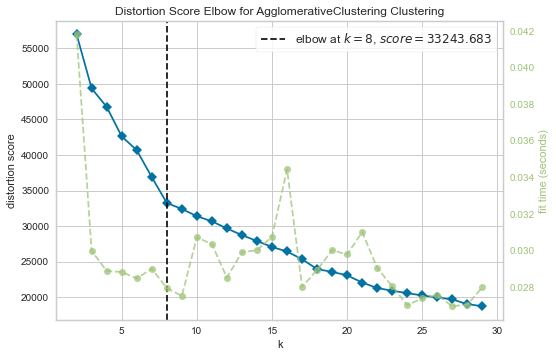

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(linkage='complete', affinity='manhattan')
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(sentiment_df.rolling(rolling_window, center=True, axis=1).mean().dropna(axis=1))        # Fit data to visualizer
visualizer.show()

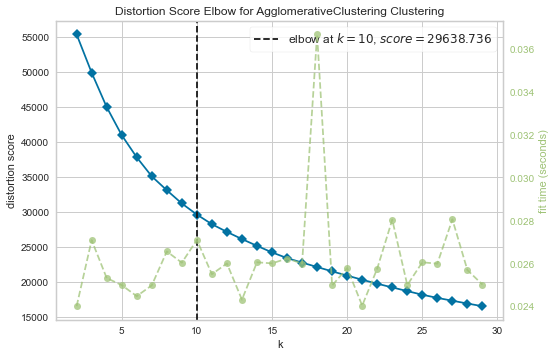

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(sentiment_df.rolling(rolling_window, center=True, axis=1).mean().dropna(axis=1))        # Fit data to visualizer
visualizer.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 8

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', affinity='manhattan')
clusters = clustering.fit_predict(sentiment_df.rolling(rolling_window, center=True, axis=1).mean().dropna(axis=1))
cluster_df = pd.DataFrame(clusters)
cluster_df.index = sentiment_df.index
print(cluster_df.value_counts())

for i in range(n_clusters):
    indices = cluster_df[cluster_df == i].dropna().index
    temp_df = sentiment_df.loc[indices].rolling(rolling_window, axis=1, center=True).mean()
    fig = go.Figure()
    for index in temp_df.index:
        fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                        mode='lines',))
    fig.update_layout(showlegend=False, 
                        width=650, 
                        height=500,
                        title='group {}'.format(i),
                        xaxis_title="Time",
                        yaxis_title="Sentiment",
                    ) 
    fig.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 10

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = clustering.fit_predict(sentiment_df.rolling(rolling_window, center=True, axis=1).mean().dropna(axis=1))
cluster_df = pd.DataFrame(clusters)
cluster_df.index = sentiment_df.index
print(cluster_df.value_counts())

for i in range(n_clusters):
    indices = cluster_df[cluster_df == i].dropna().index
    temp_df = sentiment_df.loc[indices].rolling(rolling_window, axis=1, center=True).mean()
    fig = go.Figure()
    for index in temp_df.index:
        fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                        mode='lines',
                        text=index, 
                        hoverinfo="text",
                        ))
    fig.update_layout(showlegend=False, 
                        width=650, 
                        height=500,
                        title='group {}'.format(i),
                        xaxis_title="Time",
                        yaxis_title="Sentiment",
                    ) 
    fig.show()